In [1]:
URL_BASE="https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/dev"
!curl $URL_BASE/callback.py --output callback.py
!curl $URL_BASE/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl $URL_BASE/models_01.py --output models_01.py
!curl $URL_BASE/plots.py --output plots.py
!curl $URL_BASE/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2515  100  2515    0     0   2390      0  0:00:01  0:00:01 --:--:--  2392
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0    855      0 --:--:-- --:--:-- --:--:--   855
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4648  100  4648    0     0   6060      0 --:--:-- --:--:-- --:--:--  6059
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2992  100  2992    0     0   3888      0 --:--:-- --:--:-- --:--:--  3895
  % Total    % Received % Xferd  Average Speed   Tim

In [2]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points
from prettytable import PrettyTable # Table of results

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

import plots
from brain_tumor_dataset import BrainTumorDataset     # Dataset
from callback import EarlyStopping, ModelCheckpoint
from trainer import Trainer          # Trainer Class
from models_01 import BrainNet_V1, BrainNet_V2, BrainNet_V3, BrainNet_V4

/home/poggers/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing Dataset | (from .mat to .npy) 📥
Download and unzip dataset

In [3]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0  838M    0  129k    0     0  65277      0  3:44:33  0:00:02  3:44:31 65302^C
mkdir: cannot create directory ‘dataset’: File exists
Archive:  data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data.zip or
        data.zip.zip, and cannot find data.zip.ZIP, period.
zsh:1: no matches found: ./tmp_dataset/*.zip
zsh:1: no matches found: ./tmp_dataset/*.zip


Convert .mat to .npy

In [4]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    image = f.get('cjdata/image')
    img = np.array(image, dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1
!rm -rf tmp_dataset

save Labels

In [5]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

# Config Device and Seed 🖥 🎲

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cpu


In [5]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

# Load Dataset and Create DataLoaders 💽

In [6]:
# Load Dataset
BATCH_SIZE = 32
EPOCHS = 15
HEADERS = ["Model", "Train loss", "Val Loss", "Train Acc", "Val Acc", "Paramers"]

dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = plots.split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [7]:
# Split train_data for training and validation
train_set, val_set = plots.split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [8]:
# Create Loaders
train_dl = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_dl = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dl))
print('Validation data: ', len(val_dl))
print('Test data: ', len(test_dl))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


# Visualization of Dataset 👀

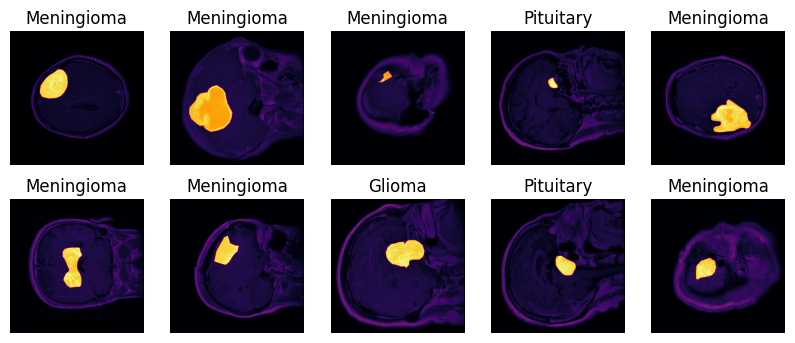

In [9]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
X_batch, y_batch = next(iter(val_dl))
plt.figure(figsize=(10, 4))
for i in range(10):
  image = (X_batch[i]*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[y_batch[i].item()-1]))
  plt.imshow(mask, cmap='inferno')

# Training 💪 🏋️

## BrainNet V1 learning rate 1e-2

In [12]:
model = BrainNet_V1()
brainnet_v1_lr2_num_params = plots.total_num_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

brainnet_v1_lr2_ckp = ModelCheckpoint('brainnet_v1_lr2.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v1_lr2_ckp)

brainnet_v1_lr2_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/15): time=00:53, train_loss=0.676, val_loss=0.834, train_acc=0.694, val_acc=0.677


Epoch 2/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/15): time=00:42, train_loss=0.513, val_loss=0.419, train_acc=0.781, val_acc=0.821


Epoch 3/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/15): time=00:47, train_loss=0.390, val_loss=1.072, train_acc=0.852, val_acc=0.611


Epoch 4/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/15): time=00:35, train_loss=0.363, val_loss=0.631, train_acc=0.852, val_acc=0.757


Epoch 5/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/15): time=00:27, train_loss=0.333, val_loss=5.686, train_acc=0.877, val_acc=0.318


Epoch 6/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/15): time=00:25, train_loss=0.301, val_loss=1.146, train_acc=0.893, val_acc=0.672


Epoch 7/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/15): time=00:25, train_loss=0.255, val_loss=0.266, train_acc=0.907, val_acc=0.887


Epoch 8/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/15): time=00:25, train_loss=0.220, val_loss=0.789, train_acc=0.919, val_acc=0.733


Epoch 9/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/15): time=00:25, train_loss=0.243, val_loss=0.453, train_acc=0.909, val_acc=0.823


Epoch 10/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/15): time=00:25, train_loss=0.246, val_loss=0.437, train_acc=0.905, val_acc=0.856


Epoch 11/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (11/15): time=00:25, train_loss=0.215, val_loss=0.275, train_acc=0.921, val_acc=0.902


Epoch 12/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (12/15): time=00:25, train_loss=0.170, val_loss=1.453, train_acc=0.933, val_acc=0.600


Epoch 13/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (13/15): time=00:24, train_loss=0.185, val_loss=1.212, train_acc=0.929, val_acc=0.754


Epoch 14/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (14/15): time=00:25, train_loss=0.232, val_loss=0.313, train_acc=0.912, val_acc=0.872


Epoch 15/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (15/15): time=00:24, train_loss=0.215, val_loss=3.959, train_acc=0.923, val_acc=0.467


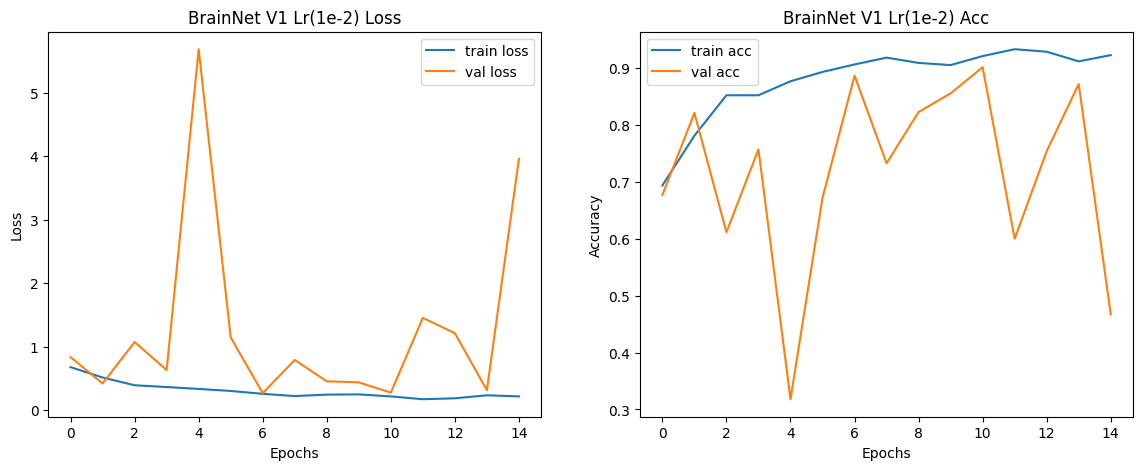

In [13]:
plots.plot_model_results("BrainNet V1 Lr(1e-2)", brainnet_v1_lr2_results)

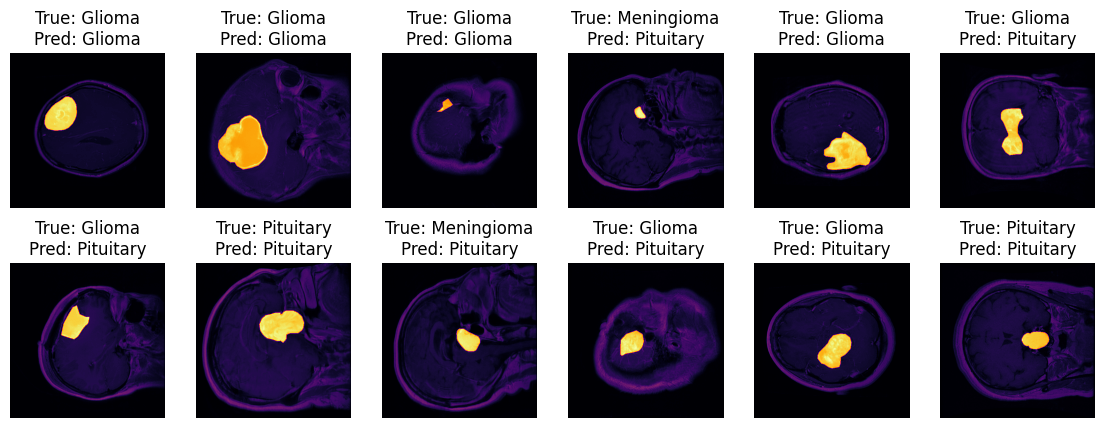

In [14]:
model = BrainNet_V1()
brainnet_v1_lr2_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [16]:
plots.print_table(HEADERS,
  [plots.row("BrainNet V1 Lr(1e-2)", brainnet_v1_lr2_ckp.best_results) + [brainnet_v1_lr2_num_params]]
)

+----------------------+------------+----------+-----------+---------+----------+
|        Model         | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+----------------------+------------+----------+-----------+---------+----------+
| BrainNet V1 Lr(1e-2) |   0.255    |  0.266   |   0.907   |  0.887  |  56299   |
+----------------------+------------+----------+-----------+---------+----------+


## BrainNet V1 learning rate 1e-2 weight decay 1e-4

In [17]:
model = BrainNet_V1()
brainnet_v1_lr2_wd4_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)

brainnet_v1_lr2_wd4_ckp = ModelCheckpoint('brainnet_v1_lr2_wd4.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v1_lr2_wd4_ckp)

brainnet_v1_lr2_wd4_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/15): time=00:35, train_loss=0.702, val_loss=1.201, train_acc=0.699, val_acc=0.515


Epoch 2/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/15): time=00:24, train_loss=0.512, val_loss=0.571, train_acc=0.789, val_acc=0.754


Epoch 3/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/15): time=00:24, train_loss=0.409, val_loss=0.419, train_acc=0.837, val_acc=0.838


Epoch 4/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/15): time=00:25, train_loss=0.394, val_loss=1.465, train_acc=0.834, val_acc=0.608


Epoch 5/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/15): time=00:25, train_loss=0.366, val_loss=0.308, train_acc=0.855, val_acc=0.872


Epoch 6/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/15): time=00:25, train_loss=0.343, val_loss=0.913, train_acc=0.869, val_acc=0.711


Epoch 7/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/15): time=00:26, train_loss=0.294, val_loss=1.830, train_acc=0.893, val_acc=0.539


Epoch 8/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/15): time=00:26, train_loss=0.271, val_loss=0.544, train_acc=0.905, val_acc=0.789


Epoch 9/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/15): time=00:26, train_loss=0.242, val_loss=0.235, train_acc=0.911, val_acc=0.898


Epoch 10/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/15): time=00:24, train_loss=0.256, val_loss=0.328, train_acc=0.905, val_acc=0.887


Epoch 11/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (11/15): time=00:25, train_loss=0.271, val_loss=1.560, train_acc=0.892, val_acc=0.603


Epoch 12/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (12/15): time=00:24, train_loss=0.228, val_loss=0.869, train_acc=0.914, val_acc=0.725


Epoch 13/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (13/15): time=00:24, train_loss=0.175, val_loss=1.185, train_acc=0.933, val_acc=0.674


Epoch 14/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (14/15): time=00:24, train_loss=0.226, val_loss=0.306, train_acc=0.919, val_acc=0.870


Epoch 15/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (15/15): time=00:24, train_loss=0.175, val_loss=4.227, train_acc=0.932, val_acc=0.425


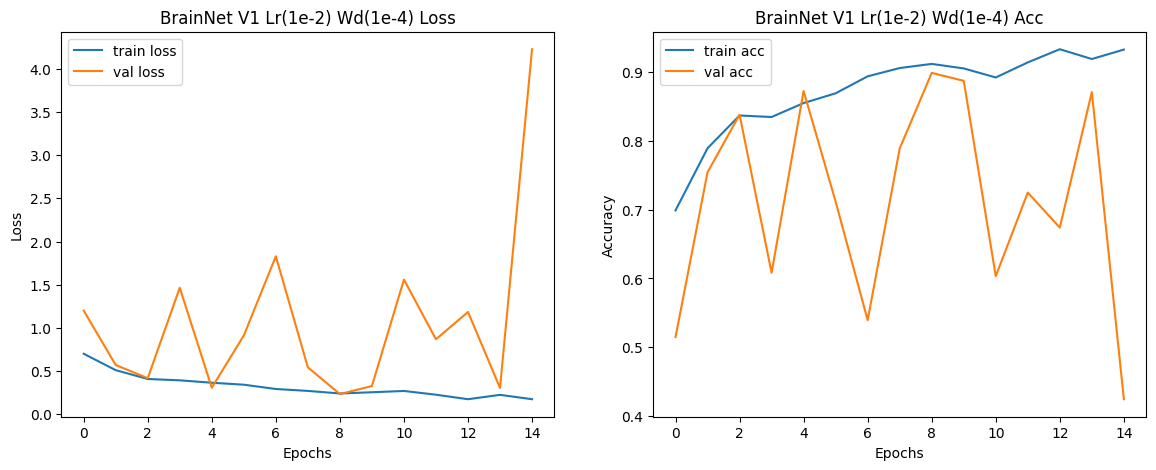

In [18]:
plots.plot_model_results("BrainNet V1 Lr(1e-2) Wd(1e-4)", brainnet_v1_lr2_wd4_results)

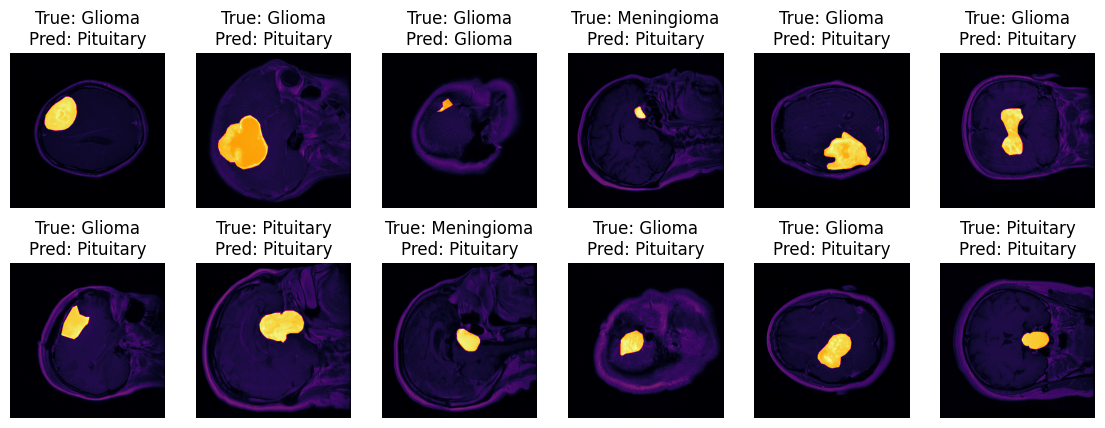

In [19]:
brainnet_v1_lr2_wd4_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [20]:
plots.print_table(HEADERS,[
plots.row("BrainNet V1 Lr(1e-2)",brainnet_v1_lr2_ckp.best_results)+[brainnet_v1_lr2_num_params],
plots.row("BrainNet V1 Lr(1e-2) Wd(1e-4)",brainnet_v1_lr2_wd4_ckp.best_results)+[brainnet_v1_lr2_wd4_num_params]
])

+-------------------------------+------------+----------+-----------+---------+----------+
|             Model             | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------------------------+------------+----------+-----------+---------+----------+
|      BrainNet V1 Lr(1e-2)     |   0.255    |  0.266   |   0.907   |  0.887  |  56299   |
| BrainNet V1 Lr(1e-2) Wd(1e-4) |   0.242    |  0.235   |   0.911   |  0.898  |  56299   |
+-------------------------------+------------+----------+-----------+---------+----------+


## BrainNet V2 learning rate 1e-2

In [21]:
model = BrainNet_V2()
brainnet_v2_lr2_num_params = plots.total_num_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

brainnet_v2_lr2_ckp = ModelCheckpoint('brainnet_v2_lr2.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v2_lr2_ckp)

brainnet_v2_lr2_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/15): time=00:30, train_loss=0.634, val_loss=2.301, train_acc=0.727, val_acc=0.415


Epoch 2/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/15): time=00:26, train_loss=0.426, val_loss=0.503, train_acc=0.838, val_acc=0.823


Epoch 3/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/15): time=00:27, train_loss=0.327, val_loss=3.793, train_acc=0.875, val_acc=0.375


Epoch 4/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/15): time=00:28, train_loss=0.281, val_loss=0.342, train_acc=0.891, val_acc=0.862


Epoch 5/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/15): time=00:26, train_loss=0.213, val_loss=11.478, train_acc=0.916, val_acc=0.262


Epoch 6/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/15): time=00:28, train_loss=0.308, val_loss=1.845, train_acc=0.882, val_acc=0.518


Epoch 7/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/15): time=00:26, train_loss=0.200, val_loss=0.617, train_acc=0.925, val_acc=0.764


Epoch 8/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/15): time=00:26, train_loss=0.215, val_loss=0.308, train_acc=0.913, val_acc=0.885


Epoch 9/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/15): time=00:26, train_loss=0.180, val_loss=0.492, train_acc=0.936, val_acc=0.854


Epoch 10/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/15): time=00:28, train_loss=0.202, val_loss=0.339, train_acc=0.922, val_acc=0.877


Epoch 11/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (11/15): time=00:26, train_loss=0.149, val_loss=0.456, train_acc=0.944, val_acc=0.848


Epoch 12/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (12/15): time=00:27, train_loss=0.156, val_loss=0.212, train_acc=0.946, val_acc=0.926


Epoch 13/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (13/15): time=00:26, train_loss=0.145, val_loss=0.270, train_acc=0.943, val_acc=0.887


Epoch 14/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (14/15): time=00:26, train_loss=0.133, val_loss=0.274, train_acc=0.952, val_acc=0.911


Epoch 15/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (15/15): time=00:25, train_loss=0.125, val_loss=0.246, train_acc=0.954, val_acc=0.913


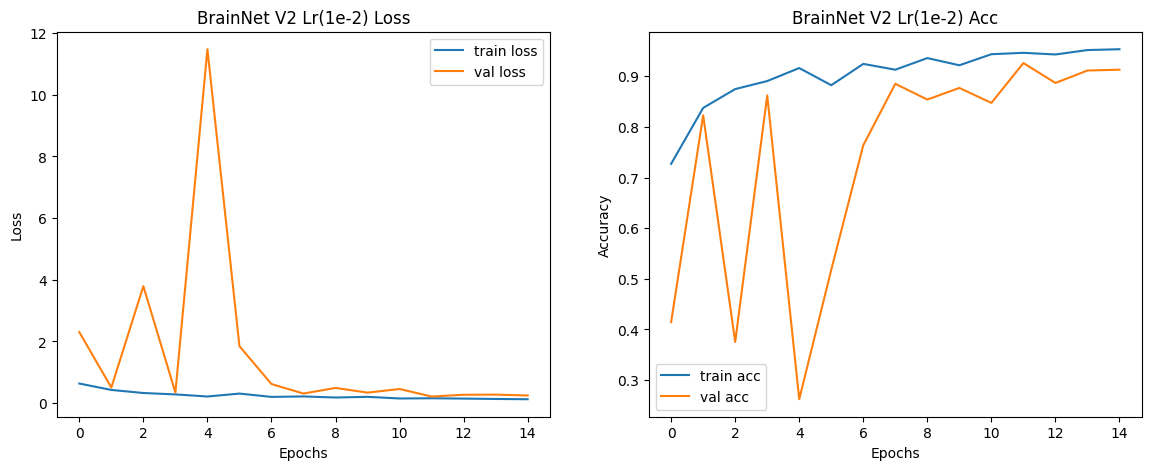

In [22]:
plots.plot_model_results("BrainNet V2 Lr(1e-2)", brainnet_v2_lr2_results)

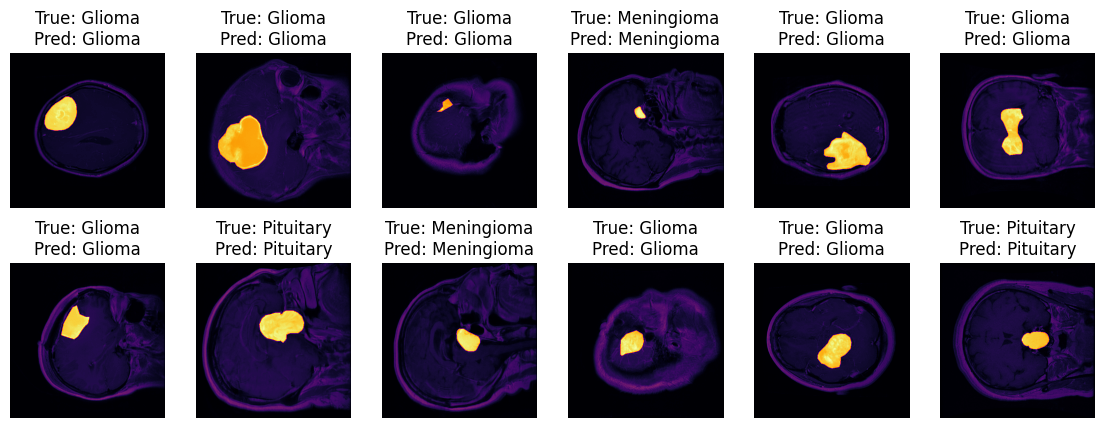

In [23]:
brainnet_v2_lr2_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [24]:
plots.print_table(HEADERS,[
plots.row("BrainNet V1 Lr(1e-2)",brainnet_v1_lr2_ckp.best_results)+[brainnet_v1_lr2_num_params],
plots.row("BrainNet V1 Lr(1e-2) Wd(1e-4)",brainnet_v1_lr2_wd4_ckp.best_results)+[brainnet_v1_lr2_wd4_num_params],
plots.row("BrainNet V2 Lr(1e-2)",brainnet_v2_lr2_ckp.best_results)+[brainnet_v2_lr2_num_params]
])

+-------------------------------+------------+----------+-----------+---------+----------+
|             Model             | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------------------------+------------+----------+-----------+---------+----------+
|      BrainNet V1 Lr(1e-2)     |   0.255    |  0.266   |   0.907   |  0.887  |  56299   |
| BrainNet V1 Lr(1e-2) Wd(1e-4) |   0.242    |  0.235   |   0.911   |  0.898  |  56299   |
|      BrainNet V2 Lr(1e-2)     |   0.156    |  0.212   |   0.946   |  0.926  |  164715  |
+-------------------------------+------------+----------+-----------+---------+----------+


## BrainNet V2 learning rate 1e-2 weight decay 1e-4

In [25]:
model = BrainNet_V2()
brainnet_v2_lr2_wd4_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)

brainnet_v2_lr2_wd4_ckp = ModelCheckpoint('brainnet_v2_lr2_wd4.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v2_lr2_wd4_ckp)

brainnet_v2_lr2_wd4_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/15): time=00:29, train_loss=0.550, val_loss=2.842, train_acc=0.776, val_acc=0.533


Epoch 2/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/15): time=00:25, train_loss=0.352, val_loss=0.433, train_acc=0.866, val_acc=0.843


Epoch 3/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/15): time=00:25, train_loss=0.345, val_loss=4.811, train_acc=0.872, val_acc=0.516


Epoch 4/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/15): time=00:25, train_loss=0.317, val_loss=3.628, train_acc=0.887, val_acc=0.516


Epoch 5/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/15): time=00:25, train_loss=0.253, val_loss=7.401, train_acc=0.912, val_acc=0.415


Epoch 6/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/15): time=00:25, train_loss=0.293, val_loss=0.990, train_acc=0.888, val_acc=0.674


Epoch 7/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/15): time=00:25, train_loss=0.214, val_loss=1.588, train_acc=0.925, val_acc=0.543


Epoch 8/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/15): time=00:25, train_loss=0.235, val_loss=1.947, train_acc=0.915, val_acc=0.670


Epoch 9/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/15): time=00:25, train_loss=0.188, val_loss=0.299, train_acc=0.930, val_acc=0.874


Epoch 10/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/15): time=00:25, train_loss=0.149, val_loss=0.705, train_acc=0.944, val_acc=0.820


Epoch 11/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (11/15): time=00:25, train_loss=0.213, val_loss=0.260, train_acc=0.921, val_acc=0.889


Epoch 12/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (12/15): time=00:25, train_loss=0.151, val_loss=0.319, train_acc=0.942, val_acc=0.872


Epoch 13/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (13/15): time=00:25, train_loss=0.167, val_loss=0.200, train_acc=0.944, val_acc=0.920


Epoch 14/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (14/15): time=00:25, train_loss=0.129, val_loss=0.318, train_acc=0.949, val_acc=0.890


Epoch 15/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (15/15): time=00:25, train_loss=0.178, val_loss=1.567, train_acc=0.930, val_acc=0.611


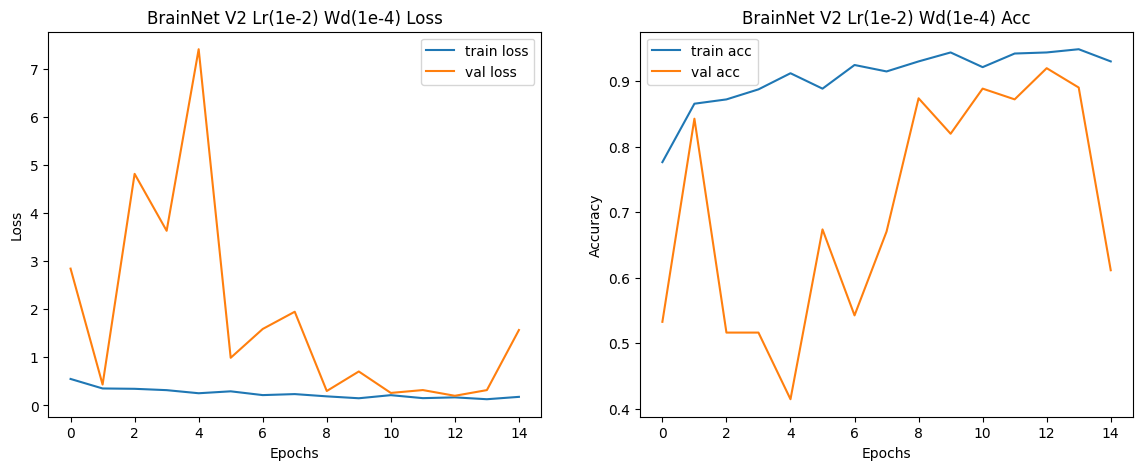

In [26]:
plots.plot_model_results("BrainNet V2 Lr(1e-2) Wd(1e-4)", brainnet_v2_lr2_wd4_results)

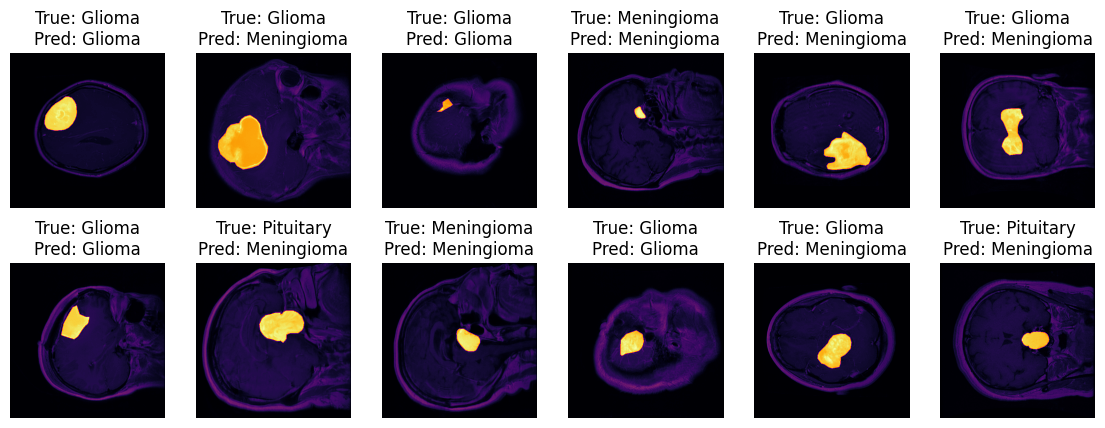

In [27]:
brainnet_v2_lr2_wd4_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [28]:
plots.print_table(HEADERS,[
plots.row("BrainNet V1 Lr(1e-2)",brainnet_v1_lr2_ckp.best_results)+[brainnet_v1_lr2_num_params],
plots.row("BrainNet V1 Lr(1e-2) Wd(1e-4)",brainnet_v1_lr2_wd4_ckp.best_results)+[brainnet_v1_lr2_wd4_num_params],
plots.row("BrainNet V2 Lr(1e-2)",brainnet_v2_lr2_ckp.best_results)+[brainnet_v2_lr2_num_params],
plots.row("BrainNet V2 Lr(1e-2) Wd(1e-4)",brainnet_v2_lr2_wd4_ckp.best_results)+[brainnet_v2_lr2_wd4_num_params]
])

+-------------------------------+------------+----------+-----------+---------+----------+
|             Model             | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------------------------+------------+----------+-----------+---------+----------+
|      BrainNet V1 Lr(1e-2)     |   0.255    |  0.266   |   0.907   |  0.887  |  56299   |
| BrainNet V1 Lr(1e-2) Wd(1e-4) |   0.242    |  0.235   |   0.911   |  0.898  |  56299   |
|      BrainNet V2 Lr(1e-2)     |   0.156    |  0.212   |   0.946   |  0.926  |  164715  |
| BrainNet V2 Lr(1e-2) Wd(1e-4) |   0.167    |  0.200   |   0.944   |  0.920  |  164715  |
+-------------------------------+------------+----------+-----------+---------+----------+


## BrainNet V3 learning rate 1e-2

In [29]:
model = BrainNet_V3()
brainnet_v3_lr2_num_params = plots.total_num_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

brainnet_v3_lr2_ckp = ModelCheckpoint('brainnet_v3_lr2.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v3_lr2_ckp)

brainnet_v3_lr2_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/15): time=00:31, train_loss=0.562, val_loss=1.604, train_acc=0.775, val_acc=0.739


Epoch 2/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/15): time=00:29, train_loss=0.427, val_loss=1.892, train_acc=0.852, val_acc=0.652


Epoch 3/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/15): time=00:29, train_loss=0.429, val_loss=0.238, train_acc=0.856, val_acc=0.915


Epoch 4/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/15): time=00:29, train_loss=0.356, val_loss=0.522, train_acc=0.884, val_acc=0.851


Epoch 5/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/15): time=00:29, train_loss=0.306, val_loss=0.706, train_acc=0.907, val_acc=0.830


Epoch 6/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/15): time=00:29, train_loss=0.323, val_loss=0.479, train_acc=0.900, val_acc=0.834


Epoch 7/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/15): time=00:29, train_loss=0.263, val_loss=0.792, train_acc=0.912, val_acc=0.659


Epoch 8/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/15): time=00:29, train_loss=0.235, val_loss=1.614, train_acc=0.921, val_acc=0.380


Epoch 9/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/15): time=00:29, train_loss=0.199, val_loss=0.307, train_acc=0.935, val_acc=0.920


Epoch 10/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/15): time=00:29, train_loss=0.215, val_loss=0.875, train_acc=0.924, val_acc=0.767


Epoch 11/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (11/15): time=00:29, train_loss=0.214, val_loss=0.152, train_acc=0.932, val_acc=0.951


Epoch 12/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (12/15): time=00:29, train_loss=0.197, val_loss=0.798, train_acc=0.931, val_acc=0.807


Epoch 13/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (13/15): time=00:29, train_loss=0.200, val_loss=0.207, train_acc=0.935, val_acc=0.939


Epoch 14/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (14/15): time=00:29, train_loss=0.198, val_loss=0.408, train_acc=0.930, val_acc=0.875


Epoch 15/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (15/15): time=00:29, train_loss=0.163, val_loss=0.505, train_acc=0.952, val_acc=0.825


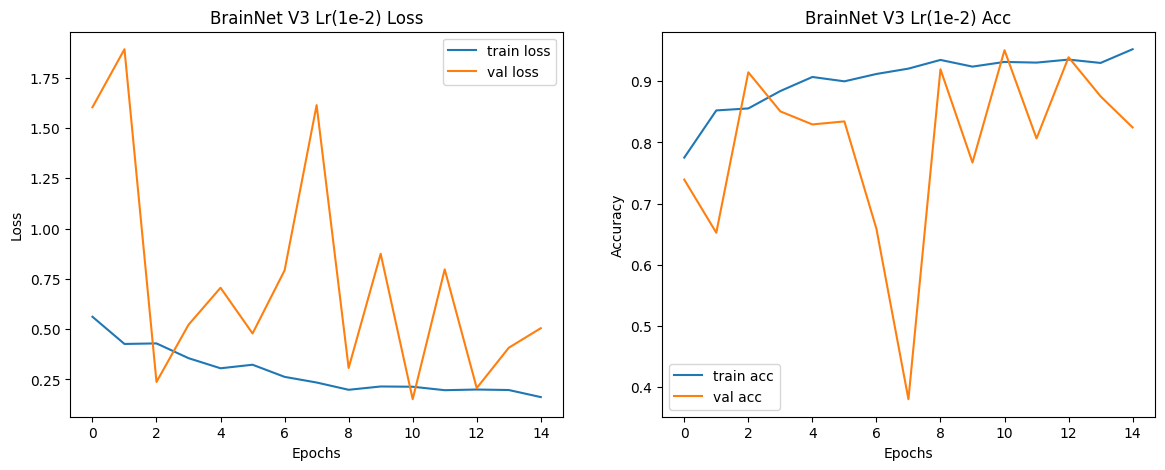

In [30]:
plots.plot_model_results("BrainNet V3 Lr(1e-2)", brainnet_v3_lr2_results)

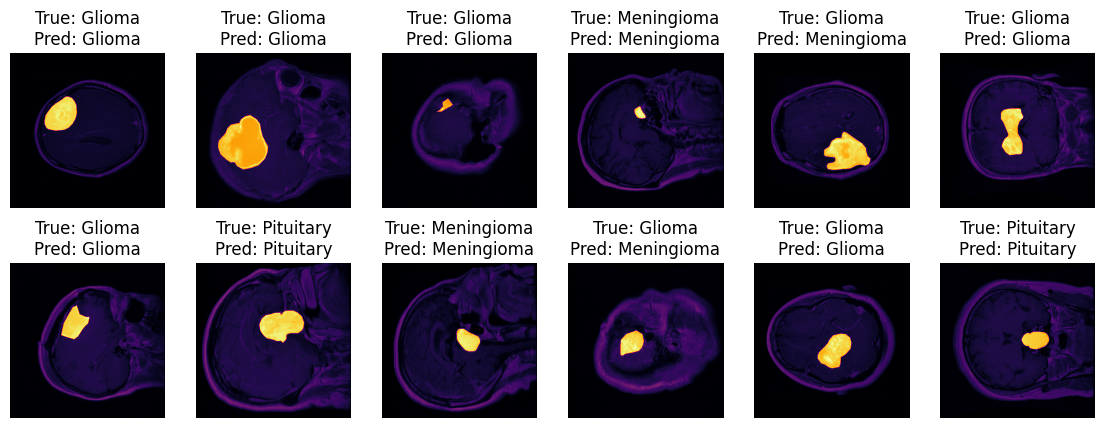

In [31]:
brainnet_v3_lr2_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [32]:
plots.print_table(HEADERS,[
plots.row("BrainNet V1 Lr(1e-2)",brainnet_v1_lr2_ckp.best_results)+[brainnet_v1_lr2_num_params],
plots.row("BrainNet V1 Lr(1e-2) Wd(1e-4)",brainnet_v1_lr2_wd4_ckp.best_results)+[brainnet_v1_lr2_wd4_num_params],
plots.row("BrainNet V2 Lr(1e-2)",brainnet_v2_lr2_ckp.best_results)+[brainnet_v2_lr2_num_params],
plots.row("BrainNet V2 Lr(1e-2) Wd(1e-4)",brainnet_v2_lr2_wd4_ckp.best_results)+[brainnet_v2_lr2_wd4_num_params],
plots.row("BrainNet V3 Lr(1e-2)",brainnet_v3_lr2_ckp.best_results)+[brainnet_v3_lr2_num_params]
])

+-------------------------------+------------+----------+-----------+---------+----------+
|             Model             | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------------------------+------------+----------+-----------+---------+----------+
|      BrainNet V1 Lr(1e-2)     |   0.255    |  0.266   |   0.907   |  0.887  |  56299   |
| BrainNet V1 Lr(1e-2) Wd(1e-4) |   0.242    |  0.235   |   0.911   |  0.898  |  56299   |
|      BrainNet V2 Lr(1e-2)     |   0.156    |  0.212   |   0.946   |  0.926  |  164715  |
| BrainNet V2 Lr(1e-2) Wd(1e-4) |   0.167    |  0.200   |   0.944   |  0.920  |  164715  |
|      BrainNet V3 Lr(1e-2)     |   0.214    |  0.152   |   0.932   |  0.951  |  427339  |
+-------------------------------+------------+----------+-----------+---------+----------+


## BrainNet V3 learning rate 1e-2 weight decay 1e-4

In [33]:
model = BrainNet_V3()
brainnet_v3_lr2_wd4_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)

brainnet_v3_lr2_wd4_ckp = ModelCheckpoint('brainnet_v3_lr2_wd4.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v3_lr2_wd4_ckp)

brainnet_v3_lr2_wd4_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/15): time=00:29, train_loss=0.555, val_loss=3.087, train_acc=0.768, val_acc=0.480


Epoch 2/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/15): time=00:29, train_loss=0.401, val_loss=8.700, train_acc=0.861, val_acc=0.516


Epoch 3/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/15): time=00:29, train_loss=0.388, val_loss=0.301, train_acc=0.856, val_acc=0.892


Epoch 4/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/15): time=00:29, train_loss=0.297, val_loss=0.439, train_acc=0.908, val_acc=0.856


Epoch 5/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/15): time=00:29, train_loss=0.288, val_loss=1.816, train_acc=0.913, val_acc=0.466


Epoch 6/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/15): time=00:29, train_loss=0.220, val_loss=0.184, train_acc=0.933, val_acc=0.938


Epoch 7/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/15): time=00:29, train_loss=0.257, val_loss=5.177, train_acc=0.907, val_acc=0.589


Epoch 8/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/15): time=00:29, train_loss=0.235, val_loss=1.632, train_acc=0.910, val_acc=0.607


Epoch 9/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/15): time=00:29, train_loss=0.291, val_loss=0.322, train_acc=0.899, val_acc=0.898


Epoch 10/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/15): time=00:29, train_loss=0.302, val_loss=0.479, train_acc=0.896, val_acc=0.852


Epoch 11/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (11/15): time=00:29, train_loss=0.206, val_loss=0.268, train_acc=0.931, val_acc=0.913


Epoch 12/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (12/15): time=00:29, train_loss=0.225, val_loss=0.134, train_acc=0.921, val_acc=0.957


Epoch 13/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (13/15): time=00:29, train_loss=0.164, val_loss=0.685, train_acc=0.948, val_acc=0.834


Epoch 14/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (14/15): time=00:29, train_loss=0.152, val_loss=0.152, train_acc=0.950, val_acc=0.949


Epoch 15/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (15/15): time=00:29, train_loss=0.171, val_loss=0.167, train_acc=0.943, val_acc=0.936


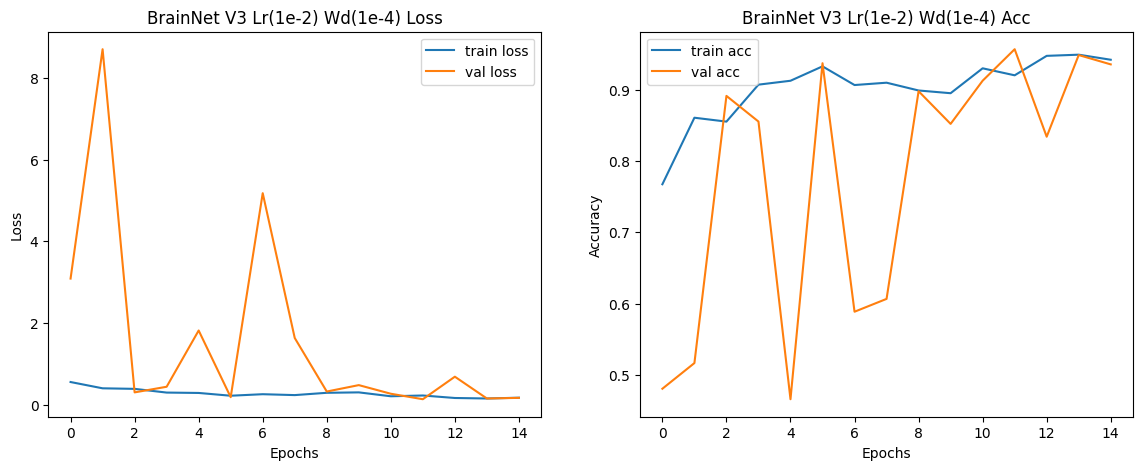

In [34]:
plots.plot_model_results("BrainNet V3 Lr(1e-2) Wd(1e-4)", brainnet_v3_lr2_wd4_results)

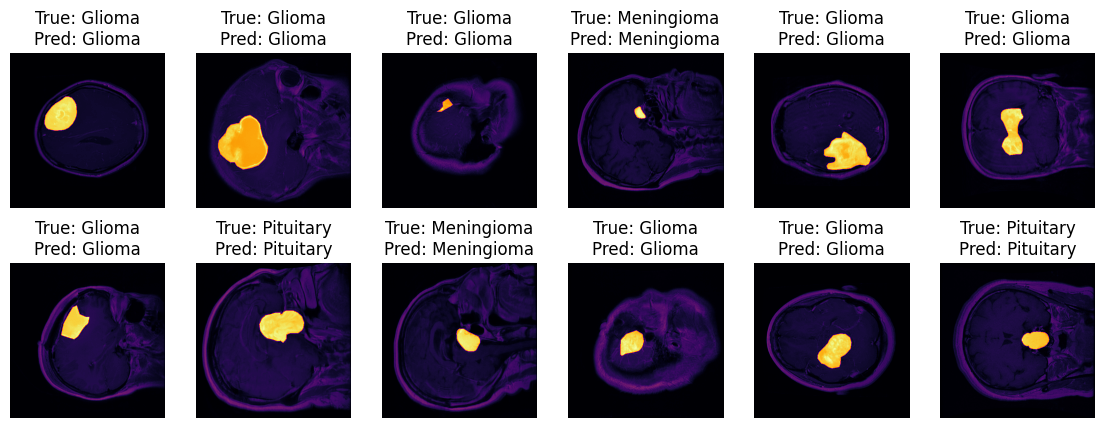

In [35]:
brainnet_v3_lr2_wd4_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [36]:
plots.print_table(HEADERS,[
plots.row("BrainNet V1 Lr(1e-2)",brainnet_v1_lr2_ckp.best_results)+[brainnet_v1_lr2_num_params],
plots.row("BrainNet V1 Lr(1e-2) Wd(1e-4)",brainnet_v1_lr2_wd4_ckp.best_results)+[brainnet_v1_lr2_wd4_num_params],
plots.row("BrainNet V2 Lr(1e-2)",brainnet_v2_lr2_ckp.best_results)+[brainnet_v2_lr2_num_params],
plots.row("BrainNet V2 Lr(1e-2) Wd(1e-4)",brainnet_v2_lr2_wd4_ckp.best_results)+[brainnet_v2_lr2_wd4_num_params],
plots.row("BrainNet V3 Lr(1e-2)",brainnet_v3_lr2_ckp.best_results)+[brainnet_v3_lr2_num_params],
plots.row("BrainNet V3 Lr(1e-2) Wd(1e-4)",brainnet_v3_lr2_wd4_ckp.best_results)+[brainnet_v3_lr2_wd4_num_params]
])

+-------------------------------+------------+----------+-----------+---------+----------+
|             Model             | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------------------------+------------+----------+-----------+---------+----------+
|      BrainNet V1 Lr(1e-2)     |   0.255    |  0.266   |   0.907   |  0.887  |  56299   |
| BrainNet V1 Lr(1e-2) Wd(1e-4) |   0.242    |  0.235   |   0.911   |  0.898  |  56299   |
|      BrainNet V2 Lr(1e-2)     |   0.156    |  0.212   |   0.946   |  0.926  |  164715  |
| BrainNet V2 Lr(1e-2) Wd(1e-4) |   0.167    |  0.200   |   0.944   |  0.920  |  164715  |
|      BrainNet V3 Lr(1e-2)     |   0.214    |  0.152   |   0.932   |  0.951  |  427339  |
| BrainNet V3 Lr(1e-2) Wd(1e-4) |   0.225    |  0.134   |   0.921   |  0.957  |  427339  |
+-------------------------------+------------+----------+-----------+---------+----------+


## BrainNet V4 learning rate 1e-2

In [38]:
model = BrainNet_V4()
brainnet_v4_lr2_num_params = plots.total_num_parameters(model)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

brainnet_v4_lr2_ckp = ModelCheckpoint('brainnet_v4_lr2.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v4_lr2_ckp)

brainnet_v4_lr2_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/15): time=00:25, train_loss=0.512, val_loss=3.125, train_acc=0.790, val_acc=0.615


Epoch 2/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/15): time=00:25, train_loss=0.362, val_loss=1.600, train_acc=0.863, val_acc=0.643


Epoch 3/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/15): time=00:26, train_loss=0.261, val_loss=0.895, train_acc=0.907, val_acc=0.674


Epoch 4/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/15): time=00:25, train_loss=0.253, val_loss=0.199, train_acc=0.910, val_acc=0.923


Epoch 5/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/15): time=00:25, train_loss=0.173, val_loss=0.981, train_acc=0.939, val_acc=0.777


Epoch 6/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/15): time=00:25, train_loss=0.220, val_loss=10.255, train_acc=0.919, val_acc=0.648


Epoch 7/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/15): time=00:25, train_loss=0.166, val_loss=0.342, train_acc=0.939, val_acc=0.892


Epoch 8/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/15): time=00:25, train_loss=0.143, val_loss=1.179, train_acc=0.941, val_acc=0.684


Epoch 9/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/15): time=00:25, train_loss=0.143, val_loss=0.193, train_acc=0.949, val_acc=0.930


Epoch 10/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/15): time=00:25, train_loss=0.206, val_loss=1.873, train_acc=0.926, val_acc=0.766


Epoch 11/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (11/15): time=00:25, train_loss=0.132, val_loss=0.837, train_acc=0.954, val_acc=0.833


Epoch 12/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (12/15): time=00:25, train_loss=0.127, val_loss=0.488, train_acc=0.957, val_acc=0.859


Epoch 13/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (13/15): time=00:25, train_loss=0.089, val_loss=0.265, train_acc=0.968, val_acc=0.925


Epoch 14/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (14/15): time=00:25, train_loss=0.121, val_loss=0.195, train_acc=0.958, val_acc=0.918


Epoch 15/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (15/15): time=00:25, train_loss=0.136, val_loss=0.597, train_acc=0.949, val_acc=0.861


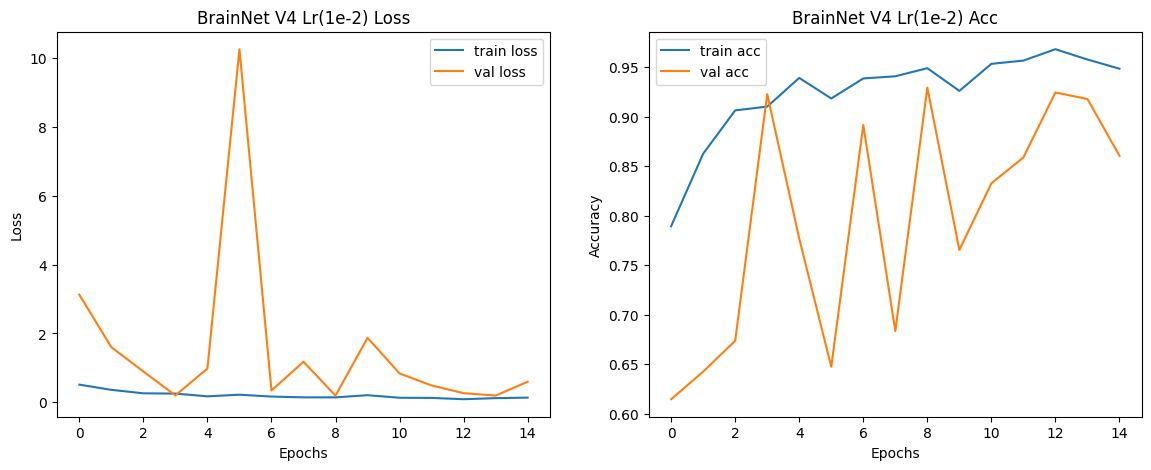

In [39]:
plots.plot_model_results("BrainNet V4 Lr(1e-2)", brainnet_v4_lr2_results)

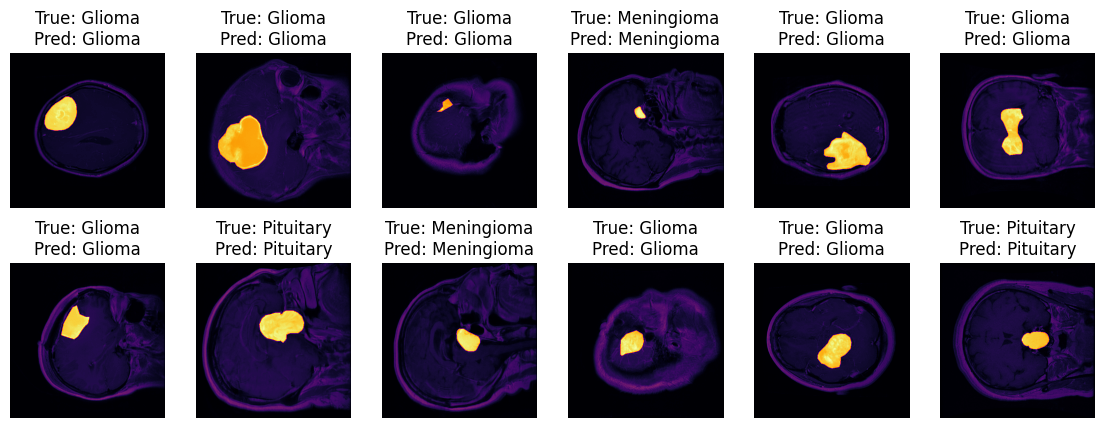

In [40]:
brainnet_v4_lr2_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [41]:
plots.print_table(HEADERS,[
plots.row("BrainNet V1 Lr(1e-2)",brainnet_v1_lr2_ckp.best_results)+[brainnet_v1_lr2_num_params],
plots.row("BrainNet V1 Lr(1e-2) Wd(1e-4)",brainnet_v1_lr2_wd4_ckp.best_results)+[brainnet_v1_lr2_wd4_num_params],
plots.row("BrainNet V2 Lr(1e-2)",brainnet_v2_lr2_ckp.best_results)+[brainnet_v2_lr2_num_params],
plots.row("BrainNet V2 Lr(1e-2) Wd(1e-4)",brainnet_v2_lr2_wd4_ckp.best_results)+[brainnet_v2_lr2_wd4_num_params],
plots.row("BrainNet V3 Lr(1e-2)",brainnet_v3_lr2_ckp.best_results)+[brainnet_v3_lr2_num_params],
plots.row("BrainNet V3 Lr(1e-2) Wd(1e-4)",brainnet_v3_lr2_wd4_ckp.best_results)+[brainnet_v3_lr2_wd4_num_params],
plots.row("BrainNet V4 Lr(1e-2)",brainnet_v4_lr2_ckp.best_results)+[brainnet_v4_lr2_num_params]
])

+-------------------------------+------------+----------+-----------+---------+----------+
|             Model             | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------------------------+------------+----------+-----------+---------+----------+
|      BrainNet V1 Lr(1e-2)     |   0.255    |  0.266   |   0.907   |  0.887  |  56299   |
| BrainNet V1 Lr(1e-2) Wd(1e-4) |   0.242    |  0.235   |   0.911   |  0.898  |  56299   |
|      BrainNet V2 Lr(1e-2)     |   0.156    |  0.212   |   0.946   |  0.926  |  164715  |
| BrainNet V2 Lr(1e-2) Wd(1e-4) |   0.167    |  0.200   |   0.944   |  0.920  |  164715  |
|      BrainNet V3 Lr(1e-2)     |   0.214    |  0.152   |   0.932   |  0.951  |  427339  |
| BrainNet V3 Lr(1e-2) Wd(1e-4) |   0.225    |  0.134   |   0.921   |  0.957  |  427339  |
|      BrainNet V4 Lr(1e-2)     |   0.143    |  0.193   |   0.949   |  0.930  |  403987  |
+-------------------------------+------------+----------+-----------+---------+----------+

## BrainNet V4 learning rate 1e-2 weight decay 1e-4

In [42]:
model = BrainNet_V4()
brainnet_v4_lr2_wd4_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)

brainnet_v4_lr2_wd4_ckp = ModelCheckpoint('brainnet_v4_lr2_wd4.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v4_lr2_wd4_ckp)

brainnet_v4_lr2_wd4_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

Epoch 1/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (1/15): time=00:25, train_loss=0.483, val_loss=5.049, train_acc=0.806, val_acc=0.541


Epoch 2/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (2/15): time=00:25, train_loss=0.346, val_loss=0.755, train_acc=0.869, val_acc=0.785


Epoch 3/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (3/15): time=00:25, train_loss=0.233, val_loss=1.072, train_acc=0.917, val_acc=0.713


Epoch 4/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (4/15): time=00:25, train_loss=0.219, val_loss=0.268, train_acc=0.915, val_acc=0.898


Epoch 5/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (5/15): time=00:25, train_loss=0.171, val_loss=0.475, train_acc=0.940, val_acc=0.861


Epoch 6/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (6/15): time=00:25, train_loss=0.148, val_loss=1.338, train_acc=0.946, val_acc=0.802


Epoch 7/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (7/15): time=00:25, train_loss=0.196, val_loss=0.150, train_acc=0.925, val_acc=0.956


Epoch 8/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (8/15): time=00:25, train_loss=0.158, val_loss=0.294, train_acc=0.940, val_acc=0.887


Epoch 9/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (9/15): time=00:25, train_loss=0.176, val_loss=0.969, train_acc=0.935, val_acc=0.669


Epoch 10/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (10/15): time=00:25, train_loss=0.123, val_loss=0.576, train_acc=0.957, val_acc=0.836


Epoch 11/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (11/15): time=00:25, train_loss=0.183, val_loss=0.437, train_acc=0.932, val_acc=0.793


Epoch 12/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (12/15): time=00:25, train_loss=0.104, val_loss=0.705, train_acc=0.958, val_acc=0.784


Epoch 13/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (13/15): time=00:25, train_loss=0.183, val_loss=0.889, train_acc=0.938, val_acc=0.675


Epoch 14/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (14/15): time=00:25, train_loss=0.115, val_loss=0.181, train_acc=0.958, val_acc=0.951


Epoch 15/15:   0%|          | 0/58 [00:00<?, ?it/s]

Validating:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch (15/15): time=00:25, train_loss=0.119, val_loss=0.560, train_acc=0.955, val_acc=0.857


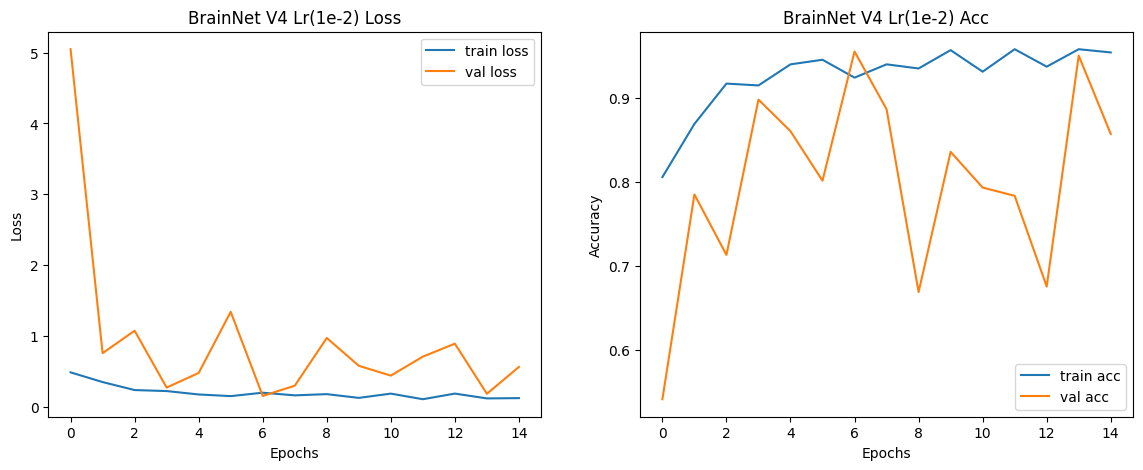

In [43]:
plots.plot_model_results("BrainNet V4 Lr(1e-2)", brainnet_v4_lr2_wd4_results)

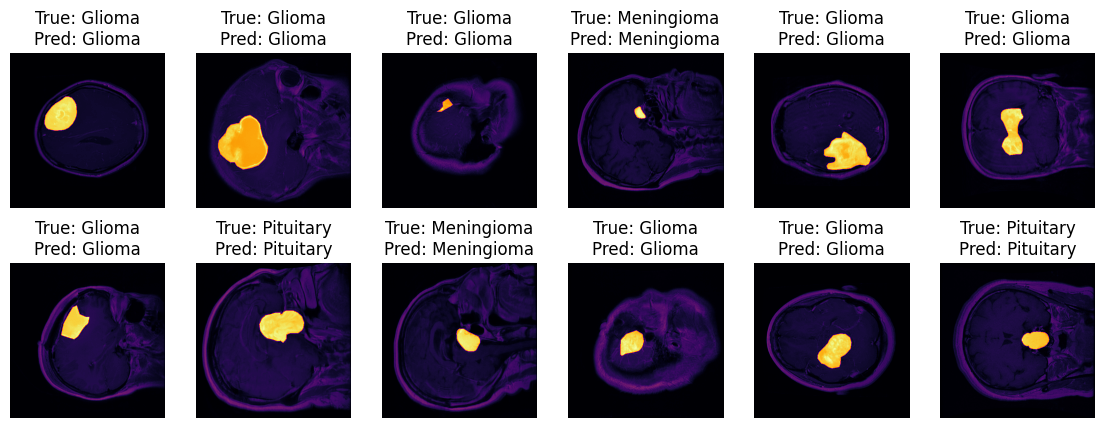

In [44]:
brainnet_v4_lr2_wd4_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [45]:
plots.print_table(HEADERS,[
plots.row("BrainNet V1 Lr(1e-2)",brainnet_v1_lr2_ckp.best_results)+[brainnet_v1_lr2_num_params],
plots.row("BrainNet V1 Lr(1e-2) Wd(1e-4)",brainnet_v1_lr2_wd4_ckp.best_results)+[brainnet_v1_lr2_wd4_num_params],
plots.row("BrainNet V2 Lr(1e-2)",brainnet_v2_lr2_ckp.best_results)+[brainnet_v2_lr2_num_params],
plots.row("BrainNet V2 Lr(1e-2) Wd(1e-4)",brainnet_v2_lr2_wd4_ckp.best_results)+[brainnet_v2_lr2_wd4_num_params],
plots.row("BrainNet V3 Lr(1e-2)",brainnet_v3_lr2_ckp.best_results)+[brainnet_v3_lr2_num_params],
plots.row("BrainNet V3 Lr(1e-2) Wd(1e-4)",brainnet_v3_lr2_wd4_ckp.best_results)+[brainnet_v3_lr2_wd4_num_params],
plots.row("BrainNet V4 Lr(1e-2)",brainnet_v4_lr2_ckp.best_results)+[brainnet_v4_lr2_num_params],
plots.row("BrainNet V4 Lr(1e-2) Wd(1e-4)",brainnet_v4_lr2_wd4_ckp.best_results)+[brainnet_v4_lr2_wd4_num_params]
])

+-------------------------------+------------+----------+-----------+---------+----------+
|             Model             | Train loss | Val Loss | Train Acc | Val Acc | Paramers |
+-------------------------------+------------+----------+-----------+---------+----------+
|      BrainNet V1 Lr(1e-2)     |   0.255    |  0.266   |   0.907   |  0.887  |  56299   |
| BrainNet V1 Lr(1e-2) Wd(1e-4) |   0.242    |  0.235   |   0.911   |  0.898  |  56299   |
|      BrainNet V2 Lr(1e-2)     |   0.156    |  0.212   |   0.946   |  0.926  |  164715  |
| BrainNet V2 Lr(1e-2) Wd(1e-4) |   0.167    |  0.200   |   0.944   |  0.920  |  164715  |
|      BrainNet V3 Lr(1e-2)     |   0.214    |  0.152   |   0.932   |  0.951  |  427339  |
| BrainNet V3 Lr(1e-2) Wd(1e-4) |   0.225    |  0.134   |   0.921   |  0.957  |  427339  |
|      BrainNet V4 Lr(1e-2)     |   0.143    |  0.193   |   0.949   |  0.930  |  403987  |
| BrainNet V4 Lr(1e-2) Wd(1e-4) |   0.196    |  0.150   |   0.925   |  0.956  |  403987  |

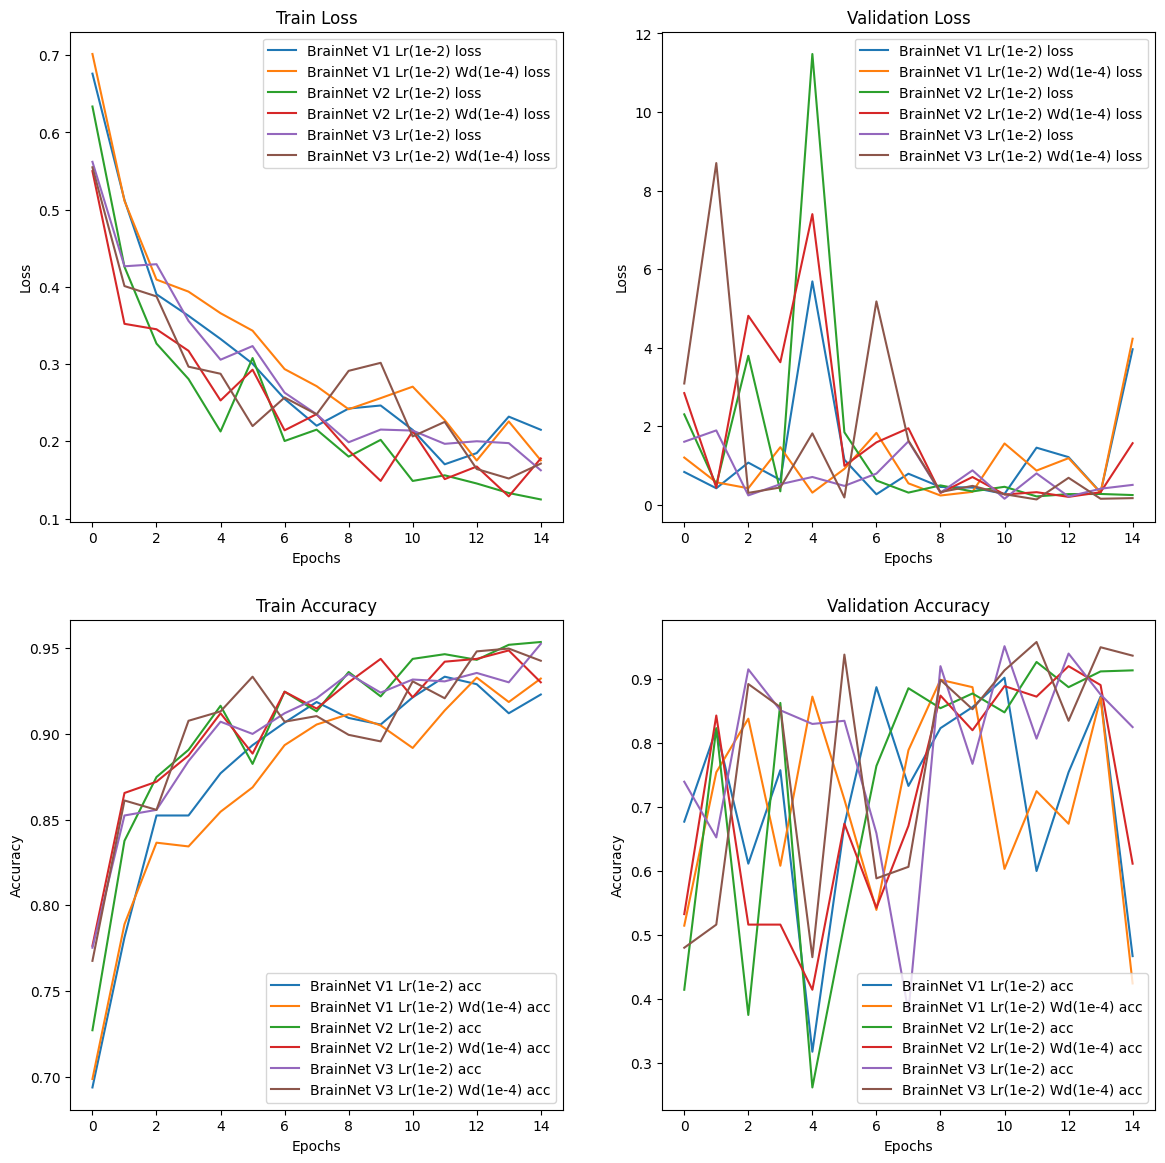

In [37]:
plots.plot_model_compare([
  ["BrainNet V1 Lr(1e-2)", brainnet_v1_lr2_results],
  ["BrainNet V1 Lr(1e-2) Wd(1e-4)", brainnet_v1_lr2_wd4_results],
  ["BrainNet V2 Lr(1e-2)", brainnet_v2_lr2_results],
  ["BrainNet V2 Lr(1e-2) Wd(1e-4)", brainnet_v2_lr2_wd4_results],
  ["BrainNet V3 Lr(1e-2)", brainnet_v3_lr2_results],
  ["BrainNet V3 Lr(1e-2) Wd(1e-4)", brainnet_v3_lr2_wd4_results],
  ["BrainNet V4 Lr(1e-2)", brainnet_v4_lr2_results],
  ["BrainNet V4 Lr(1e-2) Wd(1e-4)", brainnet_v4_lr2_wd4_results]
])

# Select Better

In [11]:
EPOCHS = 25

## BrainNet V3 Lr(1e-3) Wr(1e-6)

In [ ]:
model = BrainNet_V3()
brainnet_v3_lr3_wr6_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)
lr_schedule = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5, 1, 0.1)

brainnet_v3_lr3_wr6_ckp = ModelCheckpoint('brainnet_v3_lr3_wr6.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v3_lr3_wr6_ckp)

brainnet_v3_lr3_wr6_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device, lr_schedule)

In [ ]:
plots.plot_model_results("BrainNet V3 Lr(1e-3) Wr(1e-6)", brainnet_v3_lr3_wr6_results)

In [ ]:
brainnet_v3_lr3_wr6_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [ ]:
plots.print_table(HEADERS,[
plots.row("BrainNet V3 Lr(1e-3) Wr(1e-6)",brainnet_v3_lr3_wr6_ckp.best_results)+[brainnet_v3_lr3_wr6_num_params],
])

## BrainNet V3 Lr(1e-4) Wr(1e-7)

In [ ]:
model = BrainNet_V3()
brainnet_v3_lr4_wr7_num_params = plots.total_num_parameters(model)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-7)
lr_schedule = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5, 1, 0.1)

brainnet_v3_lr4_wr7_ckp = ModelCheckpoint('brainnet_v3_lr4_wr7.pt', mode='min', monitor='val_loss', verbose=False)

trainer = Trainer(brainnet_v3_lr4_wr7_ckp)

brainnet_v3_lr4_wr7_results = trainer.train(train_dl, val_dl, model, EPOCHS, optimizer, device)

In [ ]:
plots.plot_model_results("BrainNet V3 Lr(1e-4)", brainnet_v3_lr4_wr7_results)

In [ ]:
brainnet_v3_lr4_wr7_ckp.load_checkpoint(model)
plots.display_random_batch_detector(model, val_dl)

In [ ]:
plots.print_table(HEADERS,[
plots.row("BrainNet V3 Lr(1e-3)",brainnet_v3_lr3_wr6_ckp.best_results)+[brainnet_v3_lr3_wr6_num_params],
plots.row("BrainNet V3 Lr(1e-4)",brainnet_v3_lr4_wr7_ckp.best_results)+[brainnet_v3_lr4_wr7_num_params]
])